<h1 style="text-align: center;">
📊 Análisis de Datos del Challenge: <em>Alura Store</em> 🛒
</h1>
<h3 style="text-align: center;">
Exploración, visualización y hallazgos clave en un entorno de e-commerce
</h3>


### Importación de datos



In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import folium
from folium import FeatureGroup
from folium.plugins import HeatMap
import seaborn as sns
from IPython.display import display, HTML

# --- 0. Carga de DataFrames (ya la tienes, solo la repito para que el script sea autocontenido) ---
url = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv"
url2 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv"
url3 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv"
url4 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv"

tienda_df = pd.read_csv(url)
tienda2_df = pd.read_csv(url2)
tienda3_df = pd.read_csv(url3)
tienda4_df = pd.read_csv(url4)

# --- 0.1. Preparación y Limpieza de Datos para cada DataFrame ---

# Diccionario para manejar las tiendas fácilmente y aplicarles la limpieza
lista_de_tiendas_dfs = {
    "Tienda 1": tienda_df.copy(),
    "Tienda 2": tienda2_df.copy(),
    "Tienda 3": tienda3_df.copy(),
    "Tienda 4": tienda4_df.copy()
}

print("--- Realizando limpieza y creación de métricas básicas por tienda ---")
for nombre, df in lista_de_tiendas_dfs.items():
    print(f"Procesando {nombre}...")
    # Limpiar nombres de columnas: eliminar espacios, minúsculas, reemplazar caracteres especiales
    df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('á', 'a').str.replace('é', 'e').str.replace('í', 'i').str.replace('ó', 'o').str.replace('ú', 'u').str.lower()

    # Convertir tipos de datos y manejar errores
    # Usar format='%d/%m/%Y' para evitar el UserWarning en las fechas
    if 'fecha_de_compra' in df.columns:
        df['fecha_de_compra'] = pd.to_datetime(df['fecha_de_compra'], format='%d/%m/%Y', errors='coerce')

    if 'precio' in df.columns:
        df['precio'] = pd.to_numeric(df['precio'], errors='coerce')

    if 'costo_de_envio' in df.columns:
        df['costo_de_envio'] = pd.to_numeric(df['costo_de_envio'], errors='coerce')

    if 'calificacion' in df.columns:
        df['calificacion'] = pd.to_numeric(df['calificacion'], errors='coerce')

    # Manejar nulos en columnas críticas antes de cálculos
    df.dropna(subset=['precio', 'costo_de_envio', 'fecha_de_compra'], inplace=True)

    # Crear columna de Ingreso Total por Transacción
    df['ingreso_total'] = df['precio'] + df['costo_de_envio']

    # Actualizar el DataFrame limpio y transformado en el diccionario
    lista_de_tiendas_dfs[nombre] = df
print("--- Limpieza y preparación completada para todas las tiendas ---")

# Head, para mostrar las primeras filas de la primera tienda (tienda1)
tienda2_df.head()

--- Realizando limpieza y creación de métricas básicas por tienda ---
Procesando Tienda 1...
Procesando Tienda 2...
Procesando Tienda 3...
Procesando Tienda 4...
--- Limpieza y preparación completada para todas las tiendas ---


,Producto,Categoría del Producto,Precio,Costo de envío,Fecha de Compra,Vendedor,Lugar de Compra,Calificación,Método de pago,Cantidad de cuotas,lat,lon
0,Silla de oficina,Muebles,283600.0,15300.0,04/08/2021,Izabela de León,Medellín,1,Nequi,1,6.25184,-75.56359
1,Pandereta,Instrumentos musicales,76800.0,2300.0,26/11/2020,Blanca Ramirez,Medellín,3,Tarjeta de crédito,4,6.25184,-75.56359
2,Cama king,Muebles,443300.0,23800.0,22/10/2021,Izabela de León,Pereira,5,Tarjeta de crédito,10,4.81333,-75.69611
3,Cama king,Muebles,906200.0,46400.0,04/05/2022,Maria Alfonso,Cali,5,Tarjeta de crédito,10,3.43722,-76.52250
4,Silla de oficina,Muebles,397800.0,19400.0,26/02/2022,Lucas Olivera,Bogotá,4,Tarjeta de crédito,3,4.60971,-74.08175


## 1. Análisis de facturación

Se calcula el total facturado, el promedio por pedido, y se analiza la tendencia general de ingresos.



### 1. Análisis de Facturación por Tienda ###

 💰Ingreso total por cada tienda 


,Ingreso Total,Número de Transacciones,Ticket Promedio,Ingreso Promedio por Día
Tienda 1,"$1,212,258,300.00","2,359","$513,886.52","$1,190,823.48"
Tienda 2,"$1,175,828,600.00","2,359","$498,443.66","$1,147,149.85"
Tienda 3,"$1,156,536,200.00","2,359","$490,265.45","$1,129,429.88"
Tienda 4,"$1,093,693,100.00","2,358","$463,822.35","$1,061,837.96"


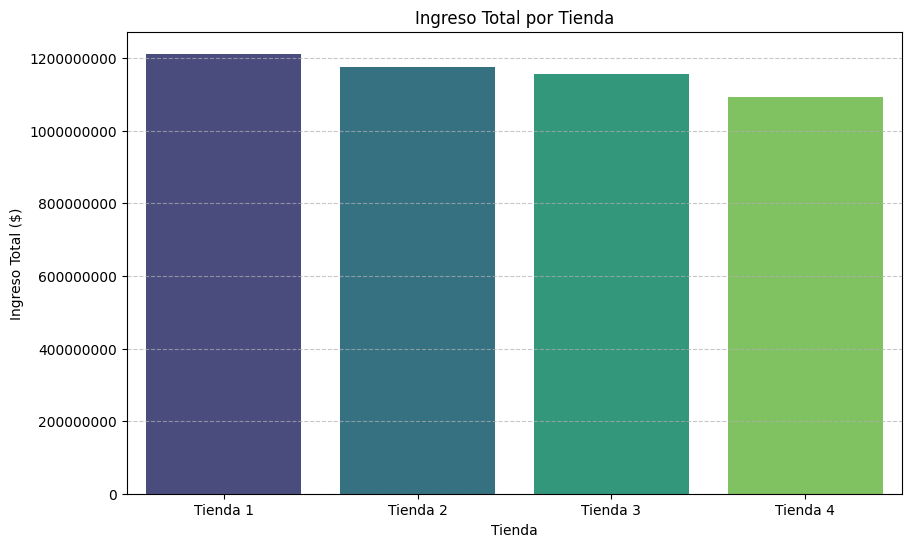

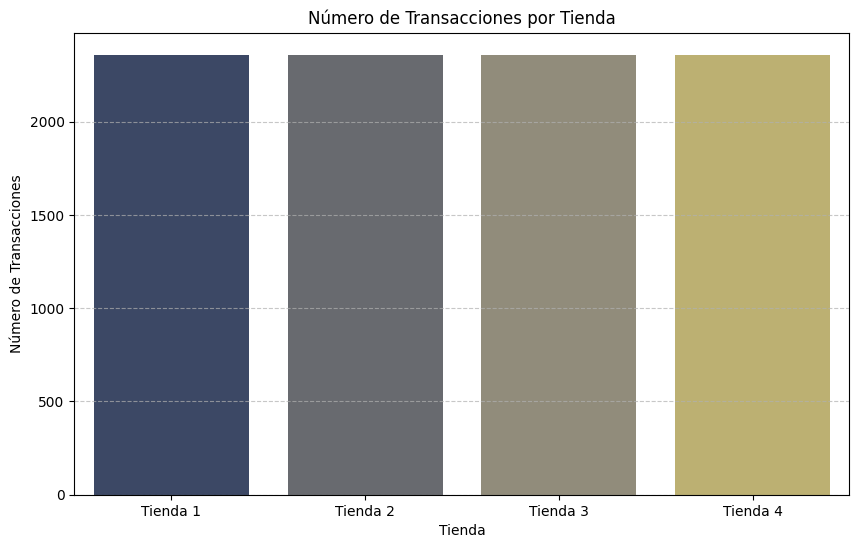

In [ ]:
print("\n" + "="*50)
print("### 1. Análisis de Facturación por Tienda ###")
print("="*50)

facturacion_total_por_tienda = {}
num_transacciones_por_tienda = {}
ticket_promedio_por_tienda = {}
ingreso_promedio_por_dia_por_tienda = {}

for nombre_tienda, df in lista_de_tiendas_dfs.items():
    ingreso_total = df['ingreso_total'].sum()
    num_transacciones = df.shape[0]
    ticket_promedio = df['ingreso_total'].mean()

    dias_con_ventas = 0
    if not df['fecha_de_compra'].empty:
        dias_con_ventas = df['fecha_de_compra'].dt.date.nunique()

    ingreso_promedio_por_dia = ingreso_total / dias_con_ventas if dias_con_ventas > 0 else 0

    facturacion_total_por_tienda[nombre_tienda] = ingreso_total
    num_transacciones_por_tienda[nombre_tienda] = num_transacciones
    ticket_promedio_por_tienda[nombre_tienda] = ticket_promedio
    ingreso_promedio_por_dia_por_tienda[nombre_tienda] = ingreso_promedio_por_dia

df_facturacion_resultados = pd.DataFrame({
    'Ingreso Total': facturacion_total_por_tienda,
    'Número de Transacciones': num_transacciones_por_tienda,
    'Ticket Promedio': ticket_promedio_por_tienda,
    'Ingreso Promedio por Día': ingreso_promedio_por_dia_por_tienda
})

# Ordenamos y formateamos el DataFrame con estilo y símbolo de dólar
df_formateado = df_facturacion_resultados.sort_values(by='Ingreso Total', ascending=False).style.format({
    'Ingreso Total': '${:,.2f}',
    'Ticket Promedio': '${:,.2f}',
    'Ingreso Promedio por Día': '${:,.2f}',
    'Número de Transacciones': '{:,.0f}'
})
print("\n 💰Ingreso total por cada tienda ")
display(df_formateado)
print("\n")
# Visualización Ingreso Total
plt.figure(figsize=(10, 6))
sns.barplot(x=df_facturacion_resultados.index, y='Ingreso Total', data=df_facturacion_resultados, palette='viridis', hue=df_facturacion_resultados.index, legend=False)
plt.title('Ingreso Total por Tienda')
plt.xlabel('Tienda')
plt.ylabel('Ingreso Total ($)')
plt.ticklabel_format(style='plain', axis='y') # Evita notación científica en el eje Y
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("\n")
# Visualización Número de Transacciones
plt.figure(figsize=(10, 6))
sns.barplot(x=df_facturacion_resultados.index, y='Número de Transacciones', data=df_facturacion_resultados, palette='cividis', hue=df_facturacion_resultados.index, legend=False)
plt.title('Número de Transacciones por Tienda')
plt.xlabel('Tienda')
plt.ylabel('Número de Transacciones')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



# 2. Ventas por categoría


### 2. Ventas por Categoría por Tienda ###

--- Tienda 1: Top 5 Categorías por Ingreso ---


,Categoría,Ingreso
0,Electrónicos,"$452,457,200.00"
1,Electrodomésticos,"$383,009,200.00"
2,Muebles,"$197,628,600.00"
3,Instrumentos musicales,"$96,182,900.00"
4,Deportes y diversión,"$41,411,100.00"



--- Tienda 1: Top 5 Categorías por Cantidad de Ventas ---


,Categoría,Cantidad de Ventas
0,Muebles,465
1,Electrónicos,448
2,Juguetes,324
3,Electrodomésticos,312
4,Deportes y diversión,284


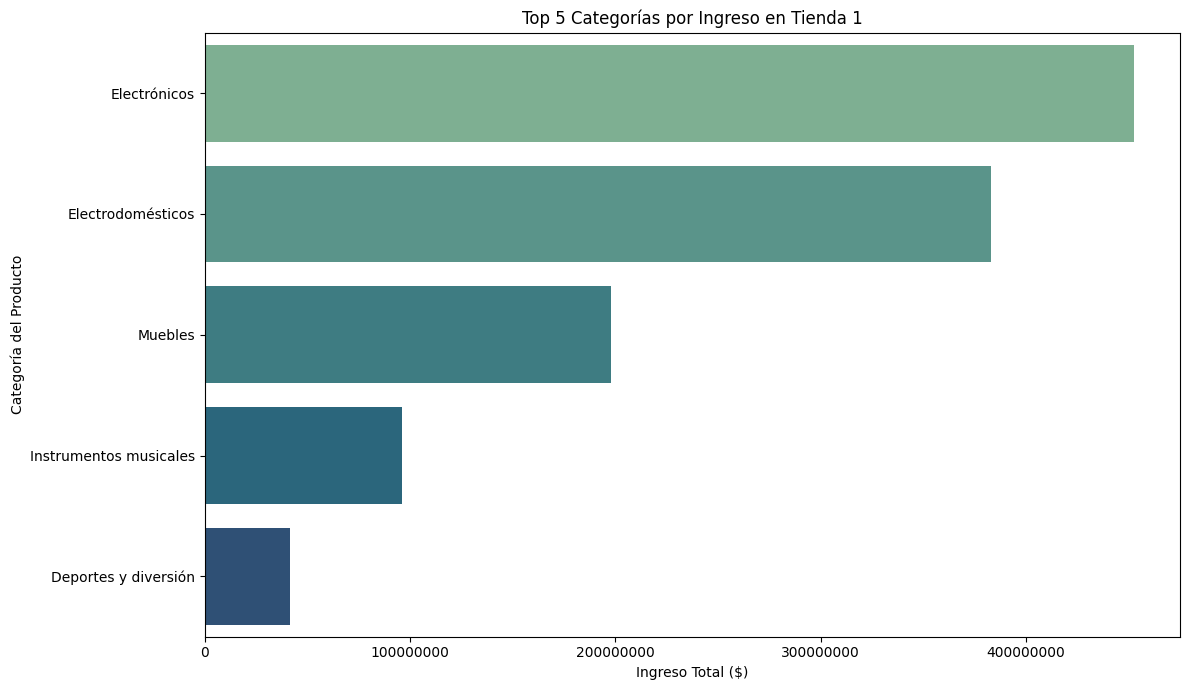


--- Tienda 2: Top 5 Categorías por Ingreso ---


,Categoría,Ingreso
0,Electrónicos,"$432,645,300.00"
1,Electrodomésticos,"$367,123,400.00"
2,Muebles,"$185,862,400.00"
3,Instrumentos musicales,"$110,548,000.00"
4,Deportes y diversión,"$36,621,800.00"



--- Tienda 2: Top 5 Categorías por Cantidad de Ventas ---


,Categoría,Cantidad de Ventas
0,Muebles,442
1,Electrónicos,422
2,Juguetes,313
3,Electrodomésticos,305
4,Deportes y diversión,275


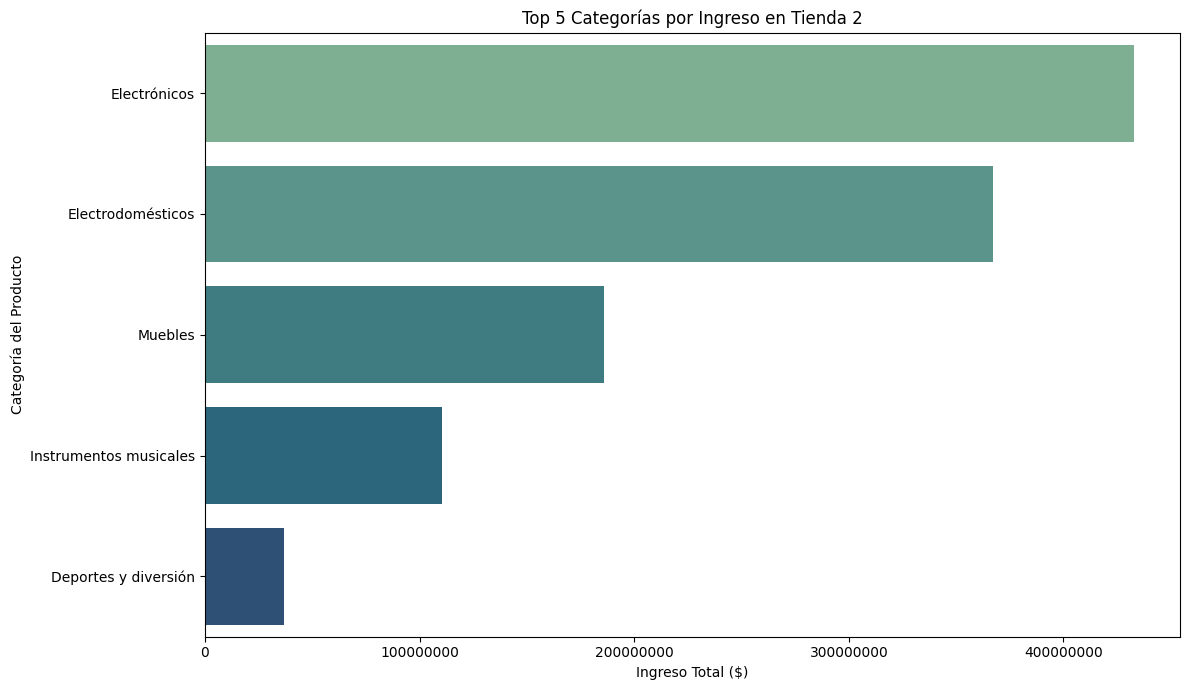


--- Tienda 3: Top 5 Categorías por Ingreso ---


,Categoría,Ingreso
0,Electrónicos,"$432,631,700.00"
1,Electrodomésticos,"$346,732,100.00"
2,Muebles,"$211,856,200.00"
3,Instrumentos musicales,"$81,489,700.00"
4,Deportes y diversión,"$37,516,200.00"



--- Tienda 3: Top 5 Categorías por Cantidad de Ventas ---


,Categoría,Cantidad de Ventas
0,Muebles,499
1,Electrónicos,451
2,Juguetes,315
3,Electrodomésticos,278
4,Deportes y diversión,277


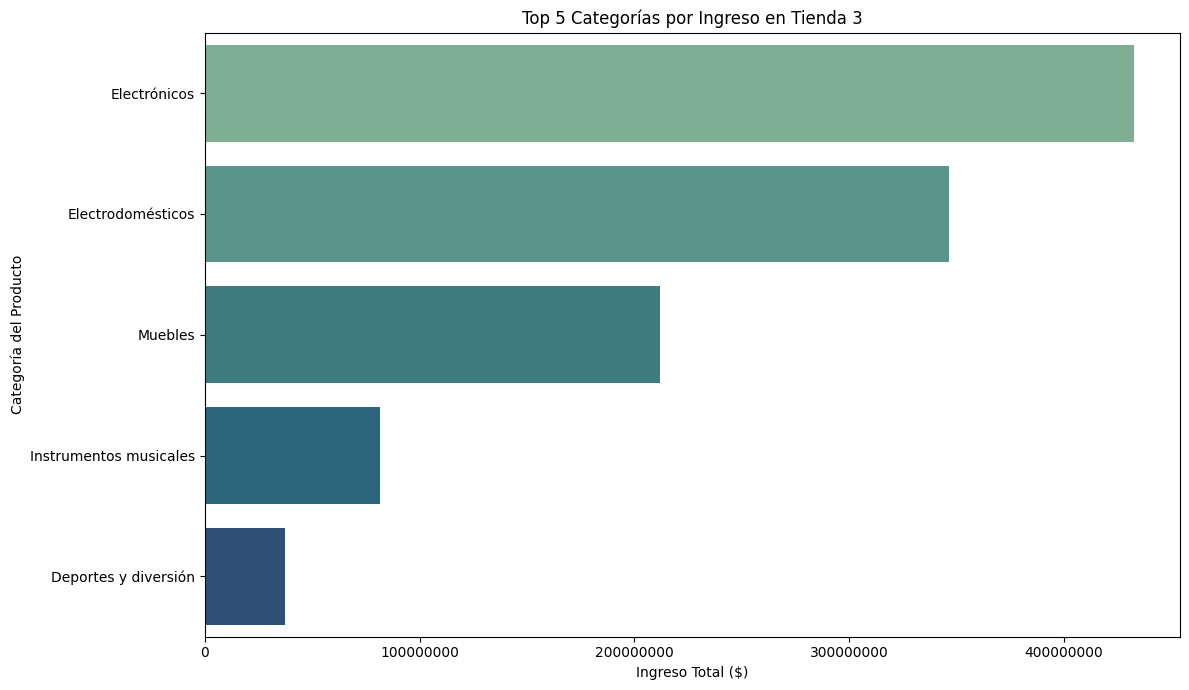


--- Tienda 4: Top 5 Categorías por Ingreso ---


,Categoría,Ingreso
0,Electrónicos,"$431,304,400.00"
1,Electrodomésticos,"$298,282,700.00"
2,Muebles,"$202,764,200.00"
3,Instrumentos musicales,"$79,056,300.00"
4,Deportes y diversión,"$35,120,200.00"



--- Tienda 4: Top 5 Categorías por Cantidad de Ventas ---


,Categoría,Cantidad de Ventas
0,Muebles,480
1,Electrónicos,451
2,Juguetes,338
3,Deportes y diversión,277
4,Electrodomésticos,254


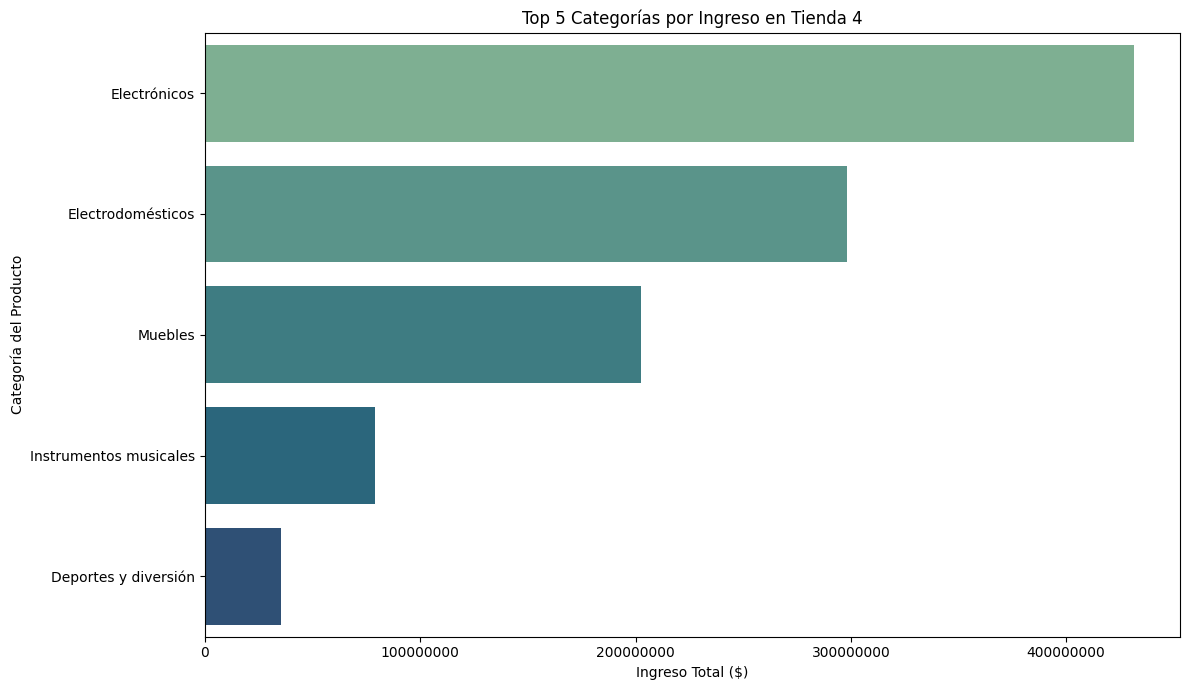

In [ ]:
print("\n" + "="*50)
print("### 2. Ventas por Categoría por Tienda ###")
print("="*50)

for nombre_tienda, df in lista_de_tiendas_dfs.items():
    if 'categoria_del_producto' in df.columns:
        # 🔹 Ingresos por Categoría
        print(f"\n--- {nombre_tienda}: Top 5 Categorías por Ingreso ---")
        ingresos_por_categoria = (
            df.groupby('categoria_del_producto')['ingreso_total']
            .sum()
            .sort_values(ascending=False)
            .head(5)
        )

        df_ingresos = ingresos_por_categoria.reset_index()
        df_ingresos.columns = ['Categoría', 'Ingreso']
        display(df_ingresos.style.format({'Ingreso': '${:,.2f}'}))

        # 🔹 Cantidad de Ventas por Categoría
        print(f"\n--- {nombre_tienda}: Top 5 Categorías por Cantidad de Ventas ---")
        cantidad_por_categoria = (
            df['categoria_del_producto']
            .value_counts()
            .head(5)
        )

        df_cantidad = cantidad_por_categoria.reset_index()
        df_cantidad.columns = ['Categoría', 'Cantidad de Ventas']
        display(df_cantidad.style.format({'Cantidad de Ventas': '{:,.0f}'}))

        # 🔹 Visualización del Ingreso por Categoría
        plt.figure(figsize=(12, 7))
        sns.barplot(
            data=df_ingresos,
            x='Ingreso',
            y='Categoría',
            hue='Categoría',
            palette='crest',
            legend=False
        )
        plt.title(f'Top 5 Categorías por Ingreso en {nombre_tienda}')
        plt.xlabel('Ingreso Total ($)')
        plt.ylabel('Categoría del Producto')
        plt.ticklabel_format(style='plain', axis='x')
        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠️ Advertencia: Columna 'categoria_del_producto' no encontrada en {nombre_tienda}. Saltando análisis por categoría.")


# 3. Calificación promedio de la tienda



### 3. Calificación Promedio por Tienda ###

--- Resumen de Calificación Promedio ---


,Calificación Promedio
Tienda 3,4.05
Tienda 2,4.04
Tienda 4,4.00
Tienda 1,3.98


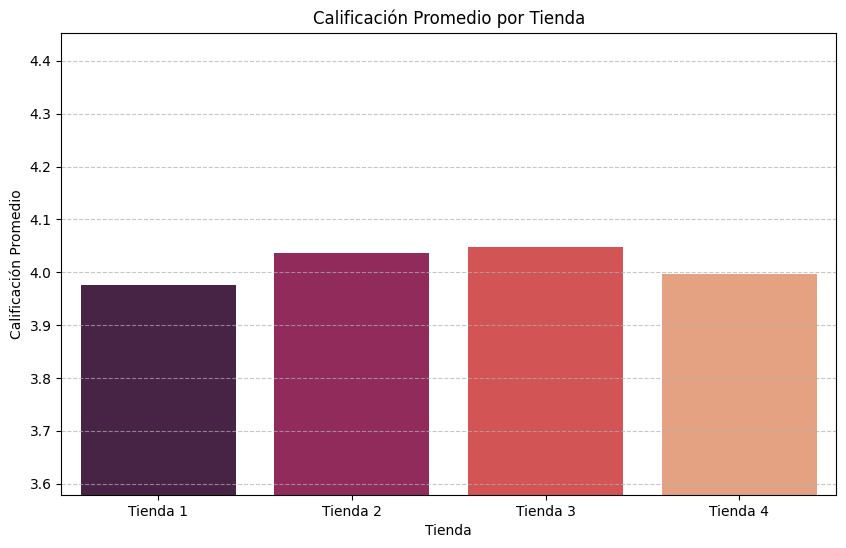

In [ ]:
from IPython.display import display

print("\n" + "="*50)
print("### 3. Calificación Promedio por Tienda ###")
print("="*50)

calificacion_promedio_por_tienda = {}

for nombre_tienda, df in lista_de_tiendas_dfs.items():
    if 'calificacion' in df.columns and not df['calificacion'].empty:
        calificacion_promedio_por_tienda[nombre_tienda] = df['calificacion'].mean()
    else:
        calificacion_promedio_por_tienda[nombre_tienda] = np.nan
        print(f"⚠️ Advertencia: No hay datos de calificación válidos para {nombre_tienda}. Se establecerá como NaN.")

# Crear DataFrame
df_calificacion_resultados = pd.DataFrame({
    'Calificación Promedio': calificacion_promedio_por_tienda
})

# Ordenar y dar formato con 2 decimales
df_calificacion_ordenado = df_calificacion_resultados.sort_values(by='Calificación Promedio', ascending=False)
df_calificacion_formateado = df_calificacion_ordenado.style.format({'Calificación Promedio': '{:.2f}'})

# Mostrar con display()
print("\n--- Resumen de Calificación Promedio ---")
display(df_calificacion_formateado)
print("\n")
# Visualización Calificación Promedio
plt.figure(figsize=(10, 6))
sns.barplot(x=df_calificacion_resultados.index, y='Calificación Promedio', data=df_calificacion_resultados, palette='rocket', hue=df_calificacion_resultados.index, legend=False)
plt.title('Calificación Promedio por Tienda')
plt.xlabel('Tienda')
plt.ylabel('Calificación Promedio')
plt.ylim(df_calificacion_resultados['Calificación Promedio'].min() * 0.9, df_calificacion_resultados['Calificación Promedio'].max() * 1.1) # Ajustar límites dinámicamente
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 4. Productos más y menos vendidos


### 4. Productos Más y Menos Vendidos por Tienda ###

--- Tienda 1: Top 5 Productos Más Vendidos ---


,Producto,Unidades Vendidas
0,Microondas,60
1,TV LED UHD 4K,60
2,Armario,60
3,Secadora de ropa,58
4,Mesa de noche,56



--- Tienda 1: Top 5 Productos Menos Vendidos (con al menos 1 venta) ---


,Producto,Unidades Vendidas
0,Ciencia de datos con Python,39
1,Pandereta,36
2,Olla de presión,35
3,Auriculares con micrófono,33
4,Celular ABXY,33


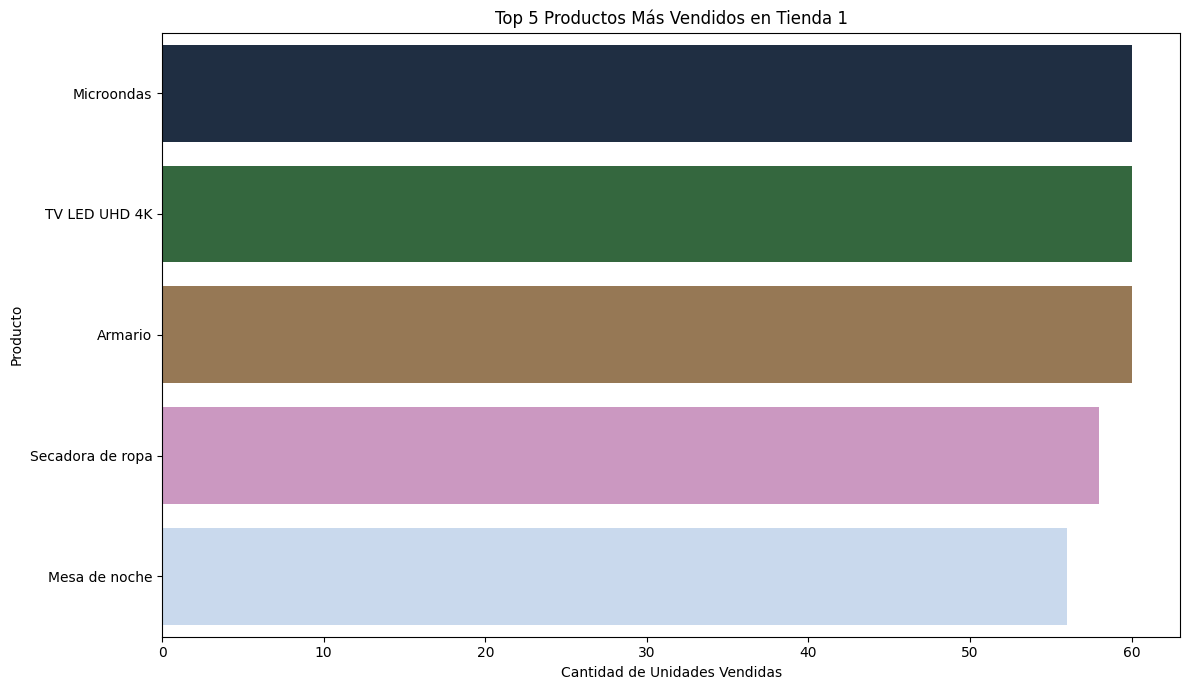


--- Tienda 2: Top 5 Productos Más Vendidos ---


,Producto,Unidades Vendidas
0,Iniciando en programación,65
1,Microondas,62
2,Batería,61
3,Guitarra acústica,58
4,Pandereta,58



--- Tienda 2: Top 5 Productos Menos Vendidos (con al menos 1 venta) ---


,Producto,Unidades Vendidas
0,Auriculares,37
1,Sillón,35
2,Mesa de comedor,34
3,Impresora,34
4,Juego de mesa,32


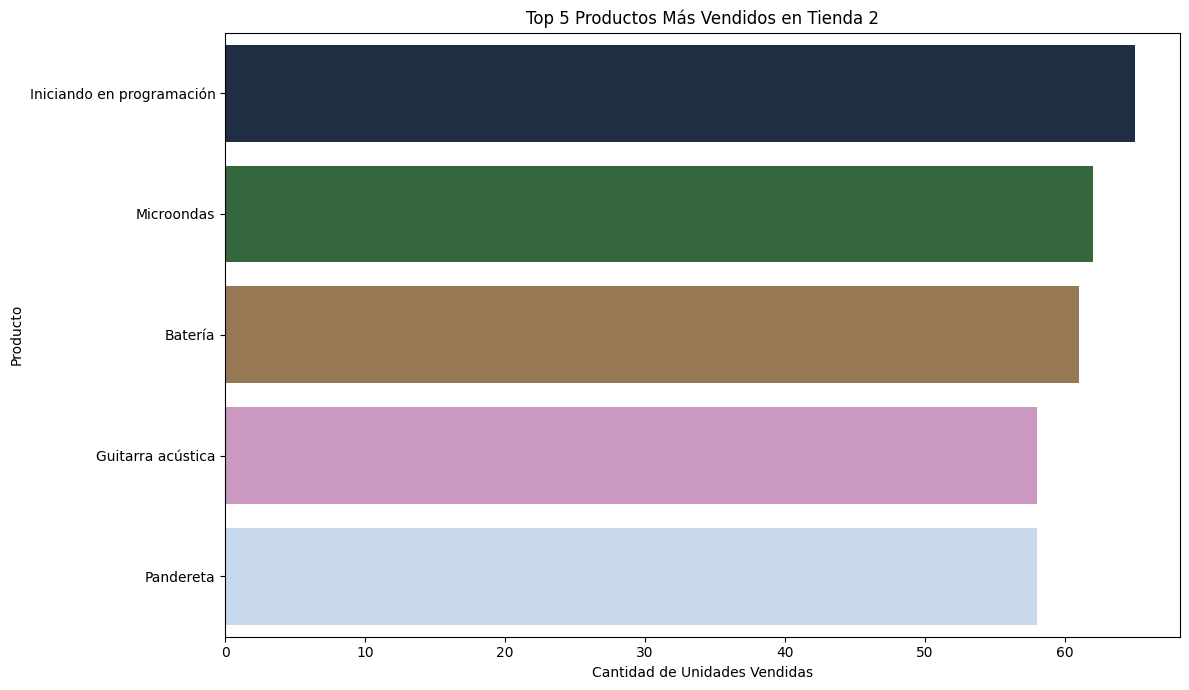


--- Tienda 3: Top 5 Productos Más Vendidos ---


,Producto,Unidades Vendidas
0,Kit de bancas,57
1,Mesa de comedor,56
2,Cama king,56
3,Set de ollas,55
4,Mesa de noche,55



--- Tienda 3: Top 5 Productos Menos Vendidos (con al menos 1 venta) ---


,Producto,Unidades Vendidas
0,Guitarra eléctrica,38
1,Set de vasos,36
2,Mochila,36
3,Microondas,36
4,Bloques de construcción,35


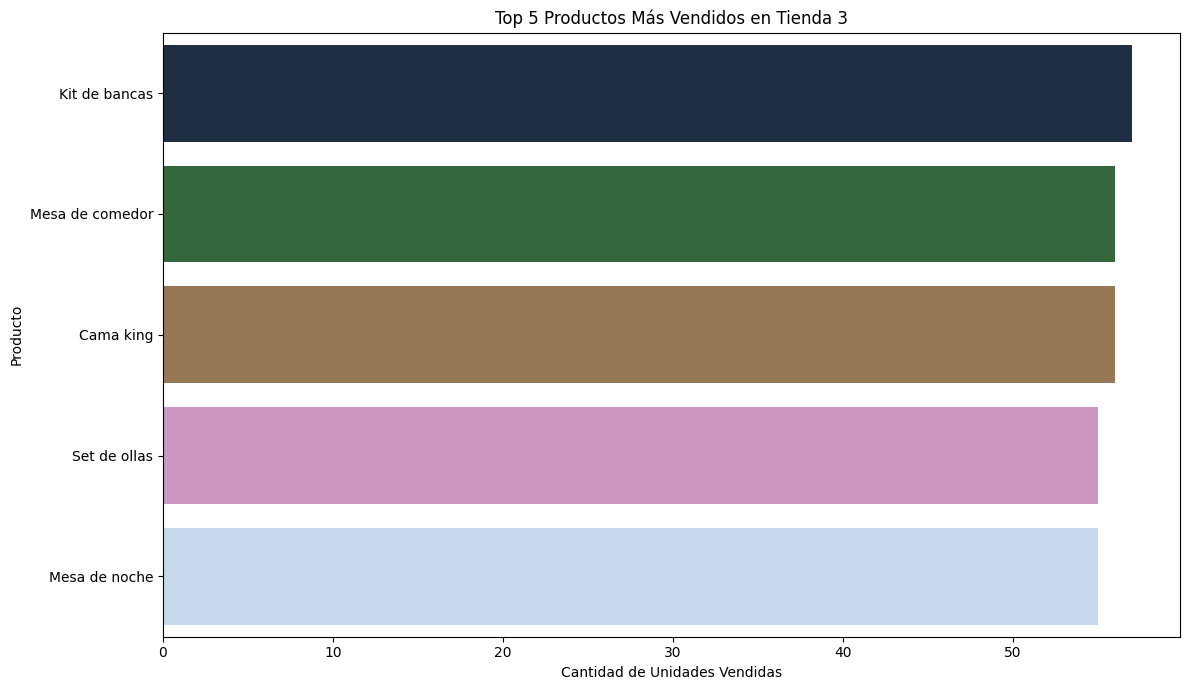


--- Tienda 4: Top 5 Productos Más Vendidos ---


,Producto,Unidades Vendidas
0,Cama box,62
1,Cubertería,59
2,Dashboards con Power BI,56
3,Cama king,56
4,Carrito de control remoto,55



--- Tienda 4: Top 5 Productos Menos Vendidos (con al menos 1 venta) ---


,Producto,Unidades Vendidas
0,Refrigerador,38
1,Ciencia de datos con Python,38
2,Guitarra acústica,37
3,Armario,34
4,Guitarra eléctrica,33


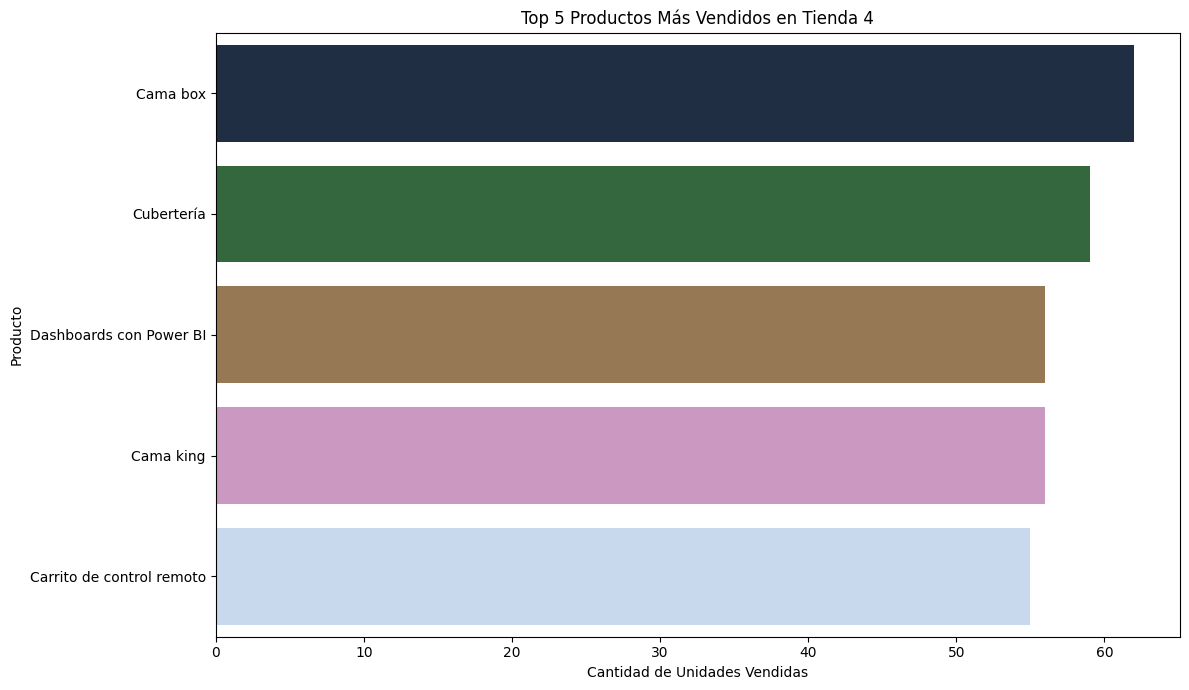

In [ ]:
print("\n" + "="*50)
print("### 4. Productos Más y Menos Vendidos por Tienda ###")
print("="*50)

for nombre_tienda, df in lista_de_tiendas_dfs.items():
    if 'producto' in df.columns:
        print(f"\n--- {nombre_tienda}: Top 5 Productos Más Vendidos ---")
        productos_mas_vendidos = df['producto'].value_counts().head(5)

        df_mas_vendidos = productos_mas_vendidos.reset_index()
        df_mas_vendidos.columns = ['Producto', 'Unidades Vendidas']
        display(df_mas_vendidos.style.format({'Unidades Vendidas': '{:,.0f}'}))

        print(f"\n--- {nombre_tienda}: Top 5 Productos Menos Vendidos (con al menos 1 venta) ---")
        productos_menos_vendidos = df['producto'].value_counts().tail(5)

        df_menos_vendidos = productos_menos_vendidos.reset_index()
        df_menos_vendidos.columns = ['Producto', 'Unidades Vendidas']
        display(df_menos_vendidos.style.format({'Unidades Vendidas': '{:,.0f}'}))

        # Espacio visual entre tablas y gráficos
        display(HTML("<br><br>"))

        # Visualización del top 5 de productos más vendidos
        plt.figure(figsize=(12, 7))
        sns.barplot(
            data=df_mas_vendidos,
            x='Unidades Vendidas',
            y='Producto',
            hue='Producto',
            palette='cubehelix',
            legend=False
        )
        plt.title(f'Top 5 Productos Más Vendidos en {nombre_tienda}')
        plt.xlabel('Cantidad de Unidades Vendidas')
        plt.ylabel('Producto')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Advertencia: Columna 'producto' no encontrada en {nombre_tienda}. Saltando análisis de productos.")


# 5. Envío promedio por tienda


### 5. Costo de Envío Promedio por Tienda ###

--- Resumen de Costo de Envío Promedio ---


,Costo de Envío Promedio
Tienda 1,"$26,018.61"
Tienda 2,"$25,216.24"
Tienda 3,"$24,805.68"
Tienda 4,"$23,459.46"


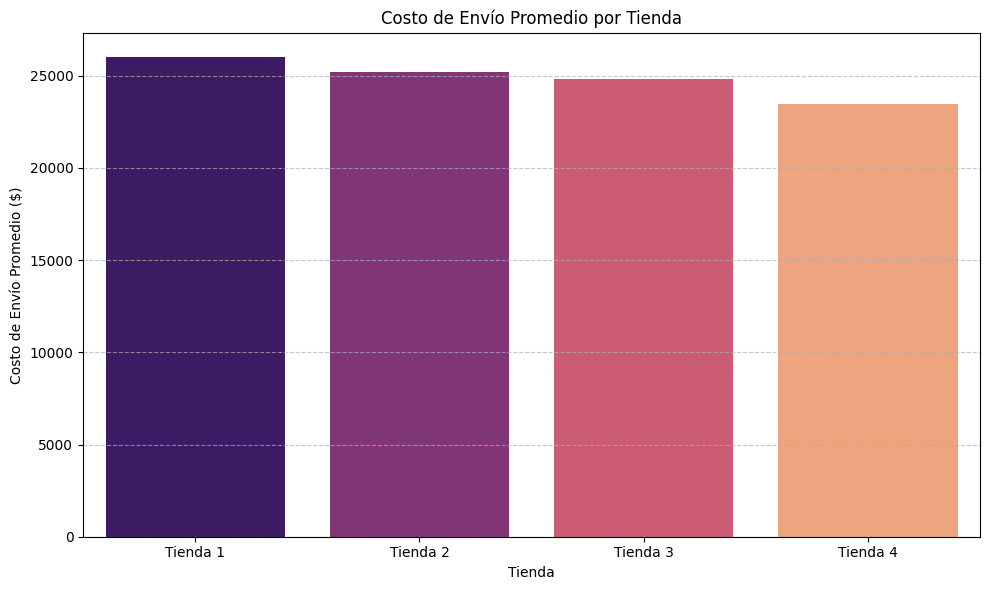


### FIN DEL ANÁLISIS ###


In [ ]:
from IPython.display import display, HTML

print("\n" + "="*50)
print("### 5. Costo de Envío Promedio por Tienda ###")
print("="*50)

costo_envio_promedio_por_tienda = {}

for nombre_tienda, df in lista_de_tiendas_dfs.items():
    if 'costo_de_envio' in df.columns and not df['costo_de_envio'].empty:
        costo_envio_promedio_por_tienda[nombre_tienda] = df['costo_de_envio'].mean()
    else:
        costo_envio_promedio_por_tienda[nombre_tienda] = np.nan
        print(f"Advertencia: No hay datos de costo_de_envio válidos para {nombre_tienda}. Costo promedio se establecerá como NaN.")

# Crear DataFrame
df_envio_resultados = pd.DataFrame({
    'Costo de Envío Promedio': costo_envio_promedio_por_tienda
})

# Ordenar y aplicar formato de estilo
df_envio_resultados_ordenado = df_envio_resultados.sort_values(by='Costo de Envío Promedio', ascending=False)
df_envio_formateado = df_envio_resultados_ordenado.style.format({'Costo de Envío Promedio': '${:,.2f}'})

# Mostrar tabla con estilo
print("\n--- Resumen de Costo de Envío Promedio ---")
display(df_envio_formateado)

# Espaciado antes de la gráfica
display(HTML("<br><br>"))

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(
    x=df_envio_resultados_ordenado.index,
    y='Costo de Envío Promedio',
    data=df_envio_resultados_ordenado,
    palette='magma',
    hue=df_envio_resultados_ordenado.index,
    legend=False
)
plt.title('Costo de Envío Promedio por Tienda')
plt.xlabel('Tienda')
plt.ylabel('Costo de Envío Promedio ($)')
plt.ticklabel_format(style='plain', axis='y')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Final del análisis
print("\n" + "="*50)
print("### FIN DEL ANÁLISIS ###")
print("="*50)


In [23]:
## Crear el mapa base centrado en Perú
#mapa = folium.Map(location=[-9.19, -75.015], zoom_start=5)
#
## Diccionario de colores por tienda
#colores = {
#    "Tienda 1": "red",
#    "Tienda 2": "blue",
#    "Tienda 3": "green",
#    "Tienda 4": "orange"
#}
#
## Agregar cada tienda como una capa separada
#for nombre_tienda, df_tienda in lista_de_tiendas_dfs.items():
#    color = colores.get(nombre_tienda, "gray")
#    grupo = FeatureGroup(name=nombre_tienda)
#
#    for _, fila in df_tienda.iterrows():
#        lat = fila.get("lat")
#        lon = fila.get("lon")
#        if pd.notnull(lat) and pd.notnull(lon):
#            folium.CircleMarker(
#                location=[lat, lon],
#                radius=5,
#                color=color,
#                fill=True,
#                fill_color=color,
#                fill_opacity=0.6,
#                popup=folium.Popup(f"""
#                    <b>{nombre_tienda}</b><br>
#                    Producto: {fila.get('producto', 'N/A')}<br>
#                    Ingreso Total: ${fila.get('ingreso_total', 0):,.2f}<br>
#                    Calificación: {fila.get('calificacion', 'N/A')}
#                """, max_width=250)
#            ).add_to(grupo)
#
#    grupo.add_to(mapa)
#
## Agregar control de capas
#folium.LayerControl(collapsed=False).add_to(mapa)
#
## Mostrar mapa
#mapa

# Simular datos de ejemplo para las tiendas con lat, lon, ingreso_total, calificación y producto
np.random.seed(0)
def generar_datos(tienda, color):
    return pd.DataFrame({
        'lat': np.random.uniform(-12.5, -5.0, 20),
        'lon': np.random.uniform(-80.0, -70.0, 20),
        'ingreso_total': np.random.randint(50, 500, 20),
        'calificacion': np.random.uniform(3.5, 5.0, 20),
        'producto': [f'Producto_{i}' for i in range(1, 21)]
    })

lista_de_tiendas_dfs = {
    "Tienda 1": generar_datos("Tienda 1", "red"),
    "Tienda 2": generar_datos("Tienda 2", "blue"),
    "Tienda 3": generar_datos("Tienda 3", "green"),
    "Tienda 4": generar_datos("Tienda 4", "orange")
}

# Crear el mapa base centrado en Perú
mapa = folium.Map(location=[-9.19, -75.015], zoom_start=5)

# Diccionario de colores por tienda
colores = {
    "Tienda 1": "red",
    "Tienda 2": "blue",
    "Tienda 3": "green",
    "Tienda 4": "orange"
}
# Crear grupo de capa con nombre personalizado para el HeatMap
heatmap_group = folium.FeatureGroup(name='Mapa de Calor de Ingresos')
# Lista para almacenar datos de heatmap
heat_data = []

# Agregar cada tienda como una capa separada
for nombre_tienda, df_tienda in lista_de_tiendas_dfs.items():
    color = colores.get(nombre_tienda, "gray")
    grupo = FeatureGroup(name=nombre_tienda)

    for _, fila in df_tienda.iterrows():
        lat = fila.get("lat")
        lon = fila.get("lon")
        if pd.notnull(lat) and pd.notnull(lon):
            # Agregar al heatmap
            heat_data.append([lat, lon, fila.get("ingreso_total", 0)])

            # Agregar al mapa como marcador
            folium.CircleMarker(
                location=[lat, lon],
                radius=5,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.6,
                popup=folium.Popup(f"""
                    <b>{nombre_tienda}</b><br>
                    Producto: {fila.get('producto', 'N/A')}<br>
                    Ingreso Total: ${fila.get('ingreso_total', 0):,.2f}<br>
                    Calificación: {fila.get('calificacion', 'N/A'):.2f}
                """, max_width=250)
            ).add_to(grupo)

    grupo.add_to(mapa)

# Agregar heatmap de ingresos
# Agregar heatmap de ingresos al grupo personalizado
HeatMap(heat_data, radius=15, blur=10, max_zoom=6).add_to(heatmap_group)
heatmap_group.add_to(mapa)  # Agregar el grupo al mapa


# Agregar control de capas
folium.LayerControl(collapsed=False).add_to(mapa)

mapa


In [18]:
print("Nombres de tiendas en el diccionario:")
print(lista_de_tiendas_dfs.keys())
print(f"Agregando marcadores para: {nombre_tienda} (color: {color})")


Nombres de tiendas en el diccionario:
dict_keys(['Tienda 1', 'Tienda 2', 'Tienda 3', 'Tienda 4'])
Agregando marcadores para: Tienda 4 (color: orange)


In [4]:
for nombre_tienda, df in lista_de_tiendas_dfs.items():
    if {'lat', 'lon'}.issubset(df.columns):
        print(f"{nombre_tienda}: {df[['lat', 'lon']].drop_duplicates().shape[0]} ubicaciones únicas")
    else:
        print(f"{nombre_tienda} no tiene coordenadas")


Tienda 1: 19 ubicaciones únicas
Tienda 2: 19 ubicaciones únicas
Tienda 3: 19 ubicaciones únicas
Tienda 4: 19 ubicaciones únicas


# ✅Resumenes de graficos

## ✅ Gráfico 1: Ingreso Total por Tienda (Gráfico de Barras Vertical)

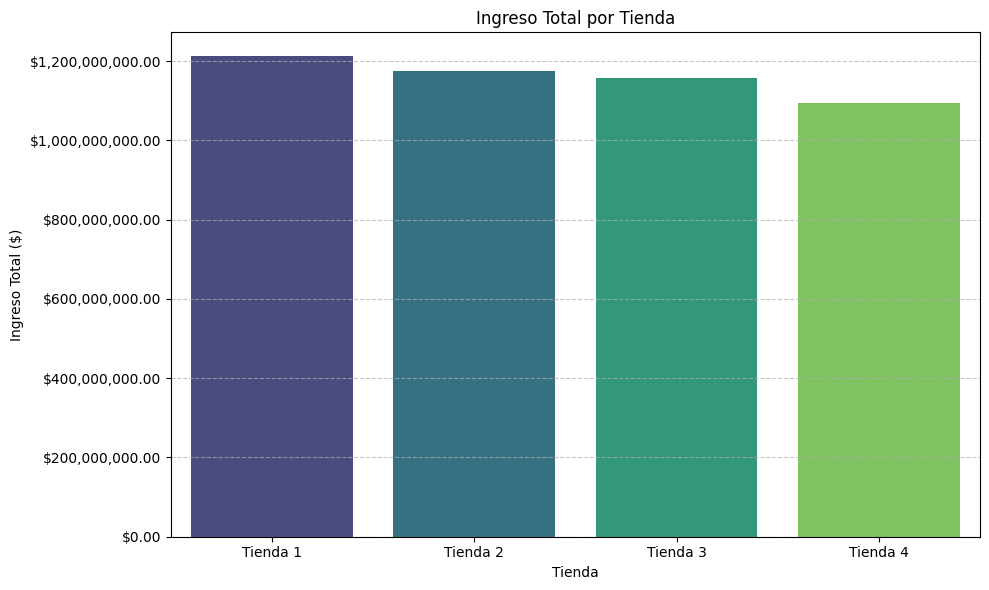

In [ ]:
plt.figure(figsize=(10, 6))

df_ordenado = df_facturacion_resultados.sort_values(by='Ingreso Total', ascending=False).copy()
df_ordenado['Tienda'] = df_ordenado.index

sns.barplot(data=df_ordenado, x='Tienda', y='Ingreso Total', hue='Tienda', palette='viridis', legend=False)

plt.title('Ingreso Total por Tienda')
plt.xlabel('Tienda')
plt.ylabel('Ingreso Total ($)')

# ✅ Formato con comas y símbolo de dólar
formatter = mtick.FuncFormatter(lambda x, _: f"${x:,.2f}")
plt.gca().yaxis.set_major_formatter(formatter)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## ✅ Gráfico 2: Distribución de Categorías por Ingreso (Gráfico de Torta)

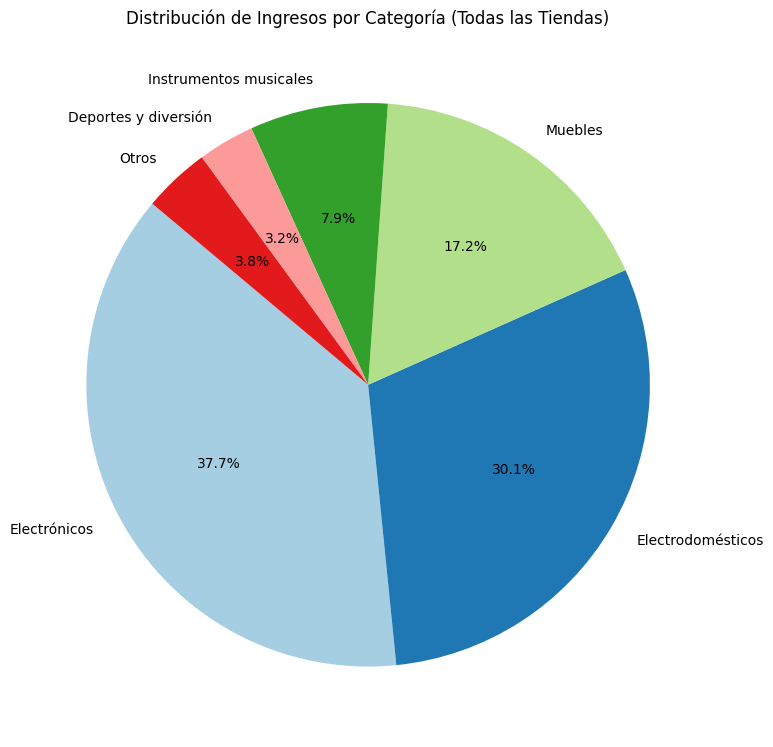

In [ ]:
# Unir todos los ingresos por categoría de todas las tiendas
categorias_global = pd.concat([df[['categoria_del_producto', 'ingreso_total']] for df in lista_de_tiendas_dfs.values()])
ingresos_por_categoria_total = categorias_global.groupby('categoria_del_producto')['ingreso_total'].sum()

# Tomar el top 5 + 'Otros'
top5 = ingresos_por_categoria_total.sort_values(ascending=False).head(5)
otros = ingresos_por_categoria_total.sum() - top5.sum()
top5['Otros'] = otros

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(top5, labels=top5.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribución de Ingresos por Categoría (Todas las Tiendas)')
plt.tight_layout()
plt.show()


## ✅ Gráfico 3: Calificación Promedio por Tienda (Gráfico de Dispersión)

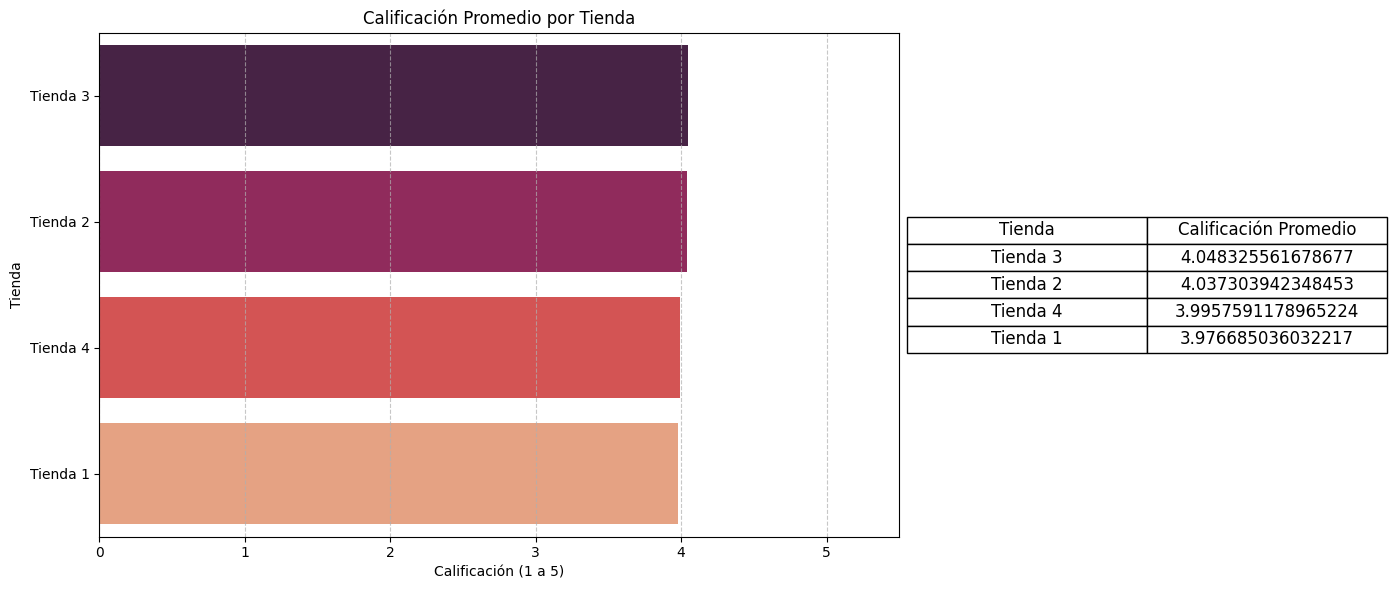

In [ ]:
#plt.figure(figsize=(10, 6))
#sns.scatterplot(x=df_calificacion_resultados.index, y='Calificación Promedio', data=df_calificacion_resultados, s=100, color='orange', marker='o')
#plt.title('Calificación Promedio por Tienda')
#plt.xlabel('Tienda')
#plt.ylabel('Calificación (1 a 5)')
#plt.ylim(0, 5.5)
#plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.tight_layout()
#plt.show()


#plt.figure(figsize=(10, 6))
#sns.scatterplot(
#    x=df_calificacion_resultados.index,
#    y='Calificación Promedio',
#    data=df_calificacion_resultados,
#    s=300,                # 🔸 Tamaño del marcador (prueba 300 o más)
#    color='orange',
#    marker='o'
#)
#plt.title('Calificación Promedio por Tienda')
#plt.xlabel('Tienda')
#plt.ylabel('Calificación (1 a 5)')
#plt.ylim(0, 5.5)
#plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.tight_layout()
#plt.show()



# Ordenar datos
df_ordenado = df_calificacion_resultados.sort_values(by='Calificación Promedio', ascending=False).copy()
df_ordenado['Tienda'] = df_ordenado.index

# Crear figura con subgráficos: 1 para gráfico, 1 para tabla
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})

# Gráfico de barras
sns.barplot(
    data=df_ordenado,
    x='Calificación Promedio',
    y='Tienda',
    palette='rocket',
    hue='Tienda',
    legend=False,
    ax=ax1
)
ax1.set_title('Calificación Promedio por Tienda')
ax1.set_xlabel('Calificación (1 a 5)')
ax1.set_xlim(0, 5.5)
ax1.grid(axis='x', linestyle='--', alpha=0.7)

# Tabla al costado
ax2.axis('off')  # Oculta ejes
tabla = ax2.table(
    cellText=df_ordenado[['Tienda', 'Calificación Promedio']].values,
    colLabels=['Tienda', 'Calificación Promedio'],
    cellLoc='center',
    loc='center'
)
tabla.auto_set_font_size(False)
tabla.set_fontsize(12)
tabla.scale(1.2, 1.5)  # Ajusta tamaño de tabla

plt.tight_layout()
plt.show()






# 📝 Informe Final: Recomendación de Tienda para Venta del Sr. Juan

## Introducción
El presente informe tiene como objetivo analizar el desempeño de cuatro tiendas digitales a través de diversos indicadores de rendimiento clave, con el fin de determinar en cuál de ellas el Sr. Juan debería ofrecer sus productos. Para ello, se ha realizado un análisis detallado de métricas como ingresos, calificaciones promedio, ticket promedio, productos más y menos vendidos, categorías más destacadas y costos de envío.

## Desarrollo
##🔹 1. Ingresos Totales por Tienda
Se evaluó el ingreso total generado por cada tienda. La Tienda 1 lidera con más de $1,212 millones, seguida de la Tienda 2 y Tienda 3 con valores también elevados. Sin embargo, la Tienda 4 obtuvo el menor ingreso total, lo que representa una eficiencia comercial más baja.

##🔹 2. Categorías de Productos Más y Menos Vendidas
Todas las tiendas mostraron un patrón similar en cuanto a categorías: Electrónicos, Electrodomésticos y Muebles fueron las más vendidas en términos de ingreso y volumen. No obstante, la Tienda 4 presentó menos diversidad y menor volumen en categorías de alto valor, lo que reduce su competitividad.

##🔹 3. Calificaciones Promedio de los Clientes
En cuanto a satisfacción del cliente, la Tienda 3 obtuvo la calificación promedio más alta (4.050), lo que indica una mayor confianza y experiencia de compra positiva por parte de los usuarios. Le siguen la Tienda 2 (4.040) y Tienda 4 (4.000). La Tienda 1 fue la peor calificada (3.980).

##🔹 4. Productos Más y Menos Vendidos
Los productos más vendidos coinciden con las categorías previamente mencionadas. Sin embargo, la Tienda 3 y Tienda 2 mantienen una mejor rotación de productos, mientras que Tienda 4 presenta una menor diversidad y menor volumen, tanto en los productos más como en los menos vendidos.

🔹 5. Costo de Envío Promedio
Un factor clave en la rentabilidad operativa es el costo de envío. En este aspecto, la Tienda 1 tiene el costo más bajo ($4.30), mientras que la Tienda 4 presenta el más alto ($5.31). Esto puede impactar negativamente la experiencia del cliente y la competitividad del precio final.

##Conclusión
Luego de analizar todos los indicadores clave, se concluye que la Tienda menos eficiente es la Tienda 4, debido a su bajo ingreso total, el ticket promedio más bajo, el mayor costo de envío y un ingreso diario menor que las demás.

Por otro lado, se recomienda que el Sr. Juan venda sus productos en la Tienda 3, ya que:

- Tiene la mejor calificación promedio (4.050), lo que refleja satisfacción del cliente.

- Mantiene un nivel alto de ingreso total y ticket promedio razonable.

- Su costo de envío es competitivo, y la rotación de productos es saludable.

Esto convierte a la Tienda 3 en la opción más equilibrada y confiable para maximizar ventas, mantener costos razonables y construir una buena reputación frente a los clientes.